# Pretrained Features Extractor

In this notebook, we explore some exposure related data augmentation, then proceed to extract features from our images using a VGG16 network, which we save to a hdf5 file.

In [1]:
%matplotlib inline

# system libraries
import os
from glob import glob
import h5py
from time import time

# numerical,image and plotting stuff
import math
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io
import skimage.transform as tf
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

We read in the available files in each class. 

There could have been re-classifications done or pictures added/removed and in our case, the current folder contents should represent the source of truth.

In [2]:
# get file names and read in images
files = glob('images/train/*/*')
files.sort()
df = pd.DataFrame({'fpath':files,'w':0,'h':0})
df['category'] = df.fpath.str.extract('images/train/Type_([0-9]*)/', expand=False).astype(np.int8) # extract class
df['fname'] = df.fpath.str.extract('images/train/[a-zA-Z0-9_]*/([0-9_.jpg]*)', expand=False) # extract file name
df = df.sort_values(['fpath'])
df.head()

fpath  h  w  category     fname
0     images/train/Type_1/0.jpg  0  0         1     0.jpg
1    images/train/Type_1/10.jpg  0  0         1    10.jpg
2  images/train/Type_1/1013.jpg  0  0         1  1013.jpg
3  images/train/Type_1/1014.jpg  0  0         1  1014.jpg
4  images/train/Type_1/1019.jpg  0  0         1  1019.jpg

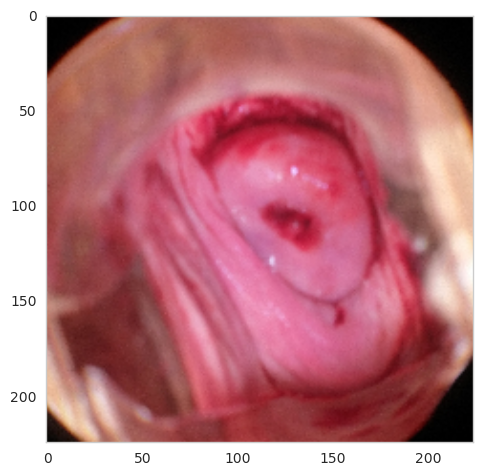

In [3]:
# prepare data
n,h,w,ch = len(df),224,224,3

# function for resizing an image
def read_resize(fpath,h=224,w=224,ch=3):
    im = Image.open(fpath)
    w_im, h_im = im.size
    if w_im < h_im: # general case
        mid_h = h_im/2
        half_w = w_im/2
        bbox = (0,mid_h-half_w,w_im,mid_h+half_w)
    else:
        print(fpath + ' is wide not long')
        mid_w = w_im/2
        half_h = h_im/2
        bbox = (mid_w-half_h,0,mid_w+half_h,h_im)
    im_sml = im.crop(bbox).resize((w,h))
    return np.asarray(im_sml)

# pre-process input for VGG16
def scale_pixels(im):
    im[:, :, :, 0] -= 103.939
    im[:, :, :, 1] -= 116.779
    im[:, :, :, 2] -= 123.68
    # 'RGB'->'BGR'
    im = im[:, :, :, ::-1]
    return im

# inverse function of scale_pixels for individual images
def unscale_pixels(im):
    # 'BGR'->'RGB'
    im = im[:, :, ::-1]
    im[:, :, 0] += 103.939
    im[:, :, 1] += 116.779
    im[:, :, 2] += 123.68
    return im

# plot a sample cropped and resized image
fpath = df.fpath.iloc[0]
im = read_resize(fpath,h,w,ch)
plt.imshow(im)

Let's try out a few exposure-related augmentations on a random subset of our images:

 - brightening
 - contrast adjustments (sigmoid and gamma)
 - CLAHE histogram equalization

In [4]:
# get a random set of 15 pictures for each type

s = 15 # number of random pictures per type
f1 = df[df.category == 1].sample(n=s,random_state=1).fpath
f2 = df[df.category == 2].sample(n=s,random_state=1).fpath
f3 = df[df.category == 3].sample(n=s,random_state=1).fpath
f = pd.concat([f1,f2,f3])

images/train/Type_1/334.jpg is wide not long


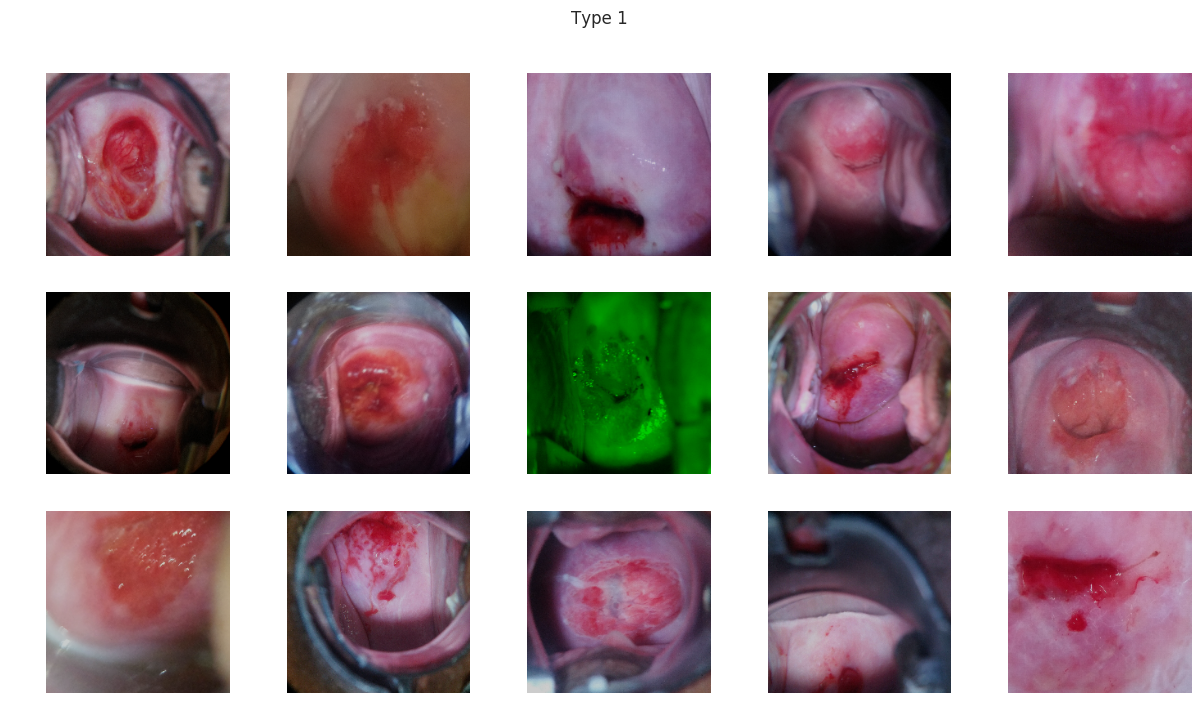

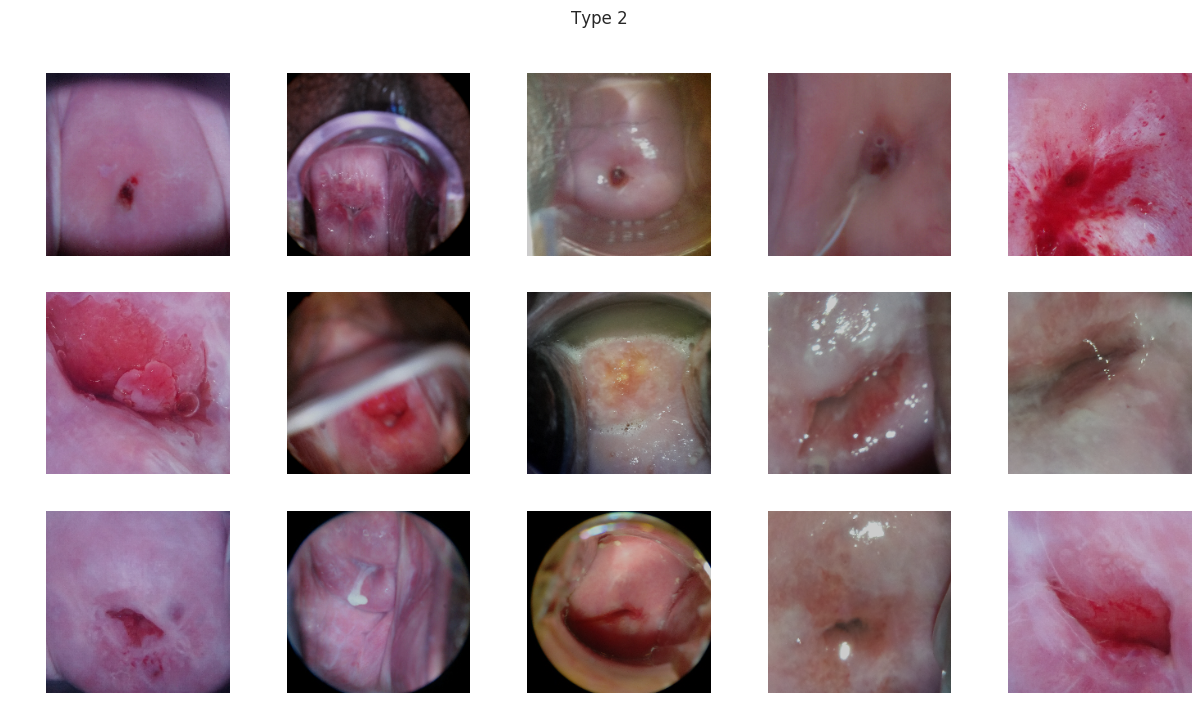

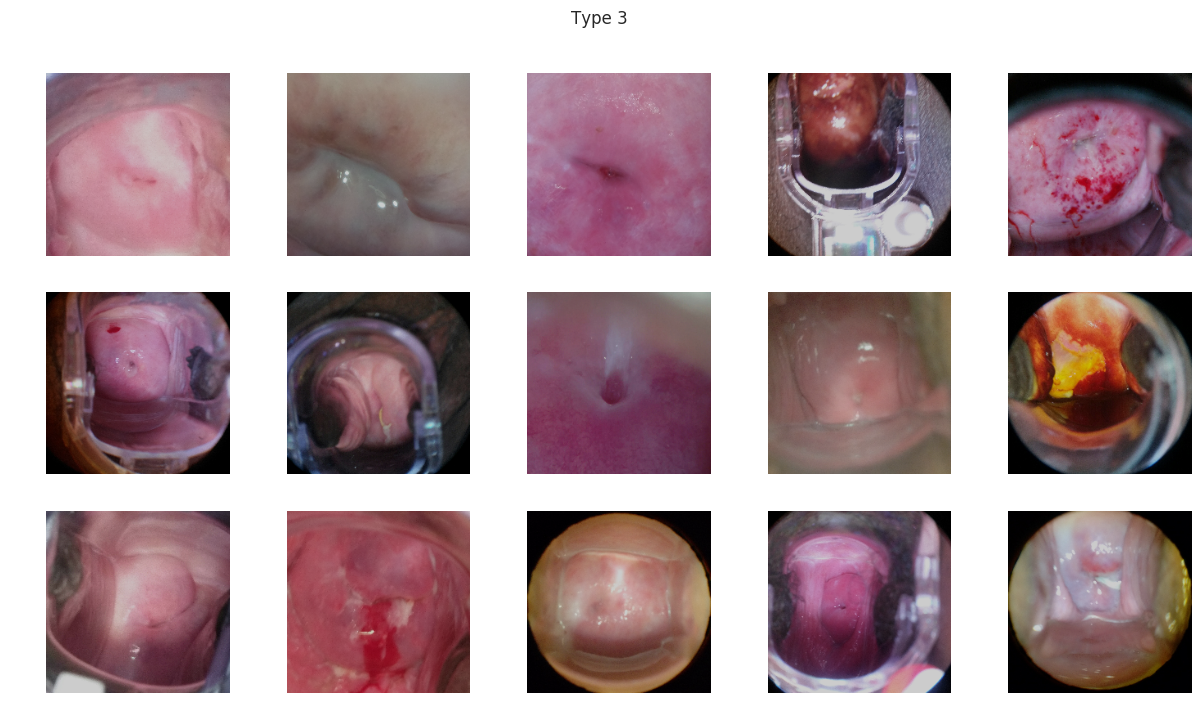

In [5]:

def brighten(im,factor):
    return np.clip(im*factor,a_max=255.,a_min=0.)

brightening_factor = 0.8
for i in range(len(f)):
    if i % 15 == 0:
        fig = plt.figure(figsize=(15,8))
        type_i = 'Type ' + str(int(i/15+1))
        plt.suptitle(type_i)
    ax = plt.subplot(3,s/3,(i%15)+1)
    im = read_resize(f.iloc[i])
    ax.imshow(brighten(im,brightening_factor)/255) # rescale to (0,1) since we have floats now
    ax.axis('off')

/opt/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


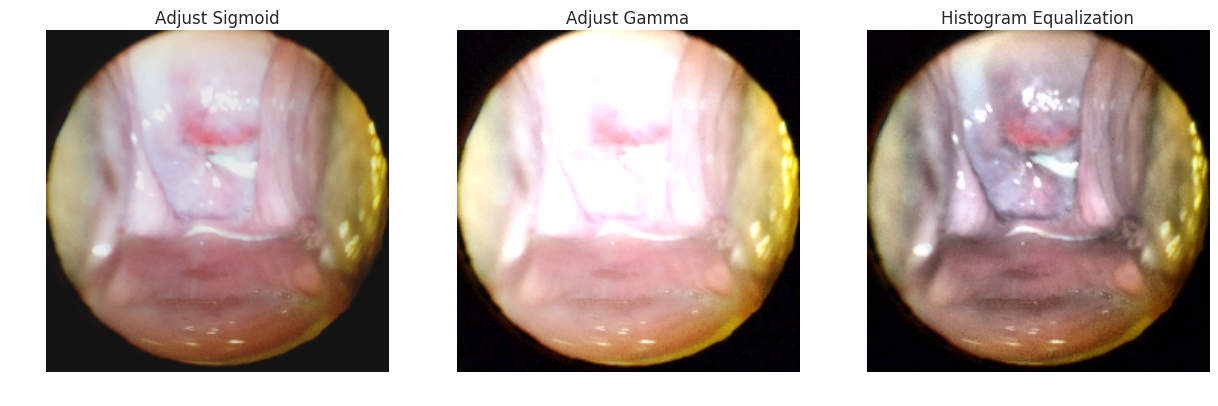

In [6]:
from skimage.exposure import adjust_gamma, adjust_sigmoid, equalize_adapthist

fig = plt.figure(figsize=(15,5))

# adjust_sigmoid
plt.subplot(131)
plt.axis('off')
plt.title('Adjust Sigmoid')
plt.imshow(adjust_sigmoid(im,cutoff=0.5,gain=5)) # feel free to play around with the cutoff and gain

# adjust_gamma
plt.subplot(132)
plt.axis('off')
plt.title('Adjust Gamma')
plt.imshow(np.clip(adjust_gamma(im/255,gamma=0.8,gain=1.3),a_max=1.,a_min=0.))

# equalize_adapthist
plt.subplot(133)
plt.axis('off')
plt.title('Histogram Equalization')
plt.imshow(equalize_adapthist(im))

Overall it would be safe to say that exposure related augmentations aren't very crucial to our datasets, and sometimes even change the actual colour which might lead to a change of diagnosis.

With that we proceed to extract the features, and build a classifier on top of it as a starting benchmark.

In [7]:
# prepare model feature extractors
from keras.applications.vgg16 import VGG16

vgg_none = VGG16(include_top=False, weights='imagenet', input_shape=None, pooling=None)

print('vgg_none output_shape: ' + str(vgg_none.output_shape))

Using TensorFlow backend.


vgg_none output_shape: (None, None, None, 512)


In [8]:
t = time()

# read in provided data
X = np.zeros((n,h,w,ch))

for i in range(len(df)):
    fpath = df.fpath.iloc[i]
    x = read_resize(fpath,h,w,ch)
    X[i,...] = x
    if i%100==0:
        print('Read %ith image' % i)

X = scale_pixels(X)
print('Reading took %is' % int(time()-t))

Read 0th image
Read 100th image
images/train/Type_1/334.jpg is wide not long
images/train/Type_1/469.jpg is wide not long
images/train/Type_1/471.jpg is wide not long
images/train/Type_1/582.jpg is wide not long
Read 200th image
images/train/Type_1/880.jpg is wide not long
images/train/Type_2/1006.jpg is wide not long
Read 300th image
images/train/Type_2/1102.jpg is wide not long
images/train/Type_2/1138.jpg is wide not long
images/train/Type_2/1144.jpg is wide not long
Read 400th image
Read 500th image
images/train/Type_2/1421.jpg is wide not long
images/train/Type_2/1444.jpg is wide not long
Read 600th image
images/train/Type_2/276.jpg is wide not long
images/train/Type_2/29.jpg is wide not long
images/train/Type_2/301.jpg is wide not long
images/train/Type_2/303.jpg is wide not long
images/train/Type_2/326.jpg is wide not long
Read 700th image
images/train/Type_2/429.jpg is wide not long
Read 800th image
images/train/Type_2/615.jpg is wide not long
images/train/Type_2/662.jpg is wid

In [9]:
# outcome labels
Y = df.category
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int8

In [10]:
%%time
features_train = vgg_none.predict(X,verbose=1)
print(features_train.shape)

1480/1480 [==============================] - 2481s   
(1480, 7, 7, 512)
CPU times: user 1h 17min 55s, sys: 4min 29s, total: 1h 22min 25s
Wall time: 41min 21s


Next, we do the same for the images in our test set.

In [11]:
t = time()

submit_img = glob('images/test/*')
n_test = len(submit_img)
X_submit = np.zeros((n_test,h,w,ch))

for i in range(n_test):
    fpath = submit_img[i]
    x = read_resize(fpath,h,w,ch)
    X_submit[i,...] = x
    if i%100==0:
        print('Read %ith image' % i)

X_submit = scale_pixels(X_submit)

print('Reading took %is' % int(time()-t))

Read 0th image
images/test/196.jpg is wide not long
Read 100th image
images/test/429.jpg is wide not long
images/test/160.jpg is wide not long
images/test/331.jpg is wide not long
Read 200th image
images/test/154.jpg is wide not long
images/test/203.jpg is wide not long
images/test/447.jpg is wide not long
images/test/16.jpg is wide not long
images/test/188.jpg is wide not long
Read 300th image
images/test/243.jpg is wide not long
images/test/74.jpg is wide not long
images/test/460.jpg is wide not long
images/test/284.jpg is wide not long
Read 400th image
images/test/58.jpg is wide not long
images/test/423.jpg is wide not long
images/test/81.jpg is wide not long
images/test/277.jpg is wide not long
Read 500th image
Reading took 181s


In [12]:
%%time
features_submit = vgg_none.predict(X_submit,verbose=1)
print(features_submit.shape)

512/512 [==============================] - 844s    
(512, 7, 7, 512)
CPU times: user 27min, sys: 1min 3s, total: 28min 4s
Wall time: 14min 4s


We save our data into a hdf5 file, for faster reading in the future. Note we've combined the code for the augmen

In [32]:
n2 = len(df_aug)

# save our input image array
f = h5py.File("data/train.h5", "w")

dX_train = f.create_dataset("train/img_cropped_resized_scaled", (n,h,w,ch), dtype='float64')
dX_train[...] = X

dX_submit = f.create_dataset("submit/img_cropped_resized_scaled", (n_test,h,w,ch), dtype='float64')
dX_submit[...] = X_submit

# save labels
dY = f.create_dataset("train/Y", (n,), dtype='int8')
dY[...] = Y

dY_aug = f.create_dataset("train/Y_aug", (n2,), dtype='int8')
dY_aug[...] = Y_aug

# save our features
df_train = f.create_dataset("train/X", (n,7,7,512), dtype='float64')
df_train[...] = features_train

df_train_aug = f.create_dataset("train/X_aug", (n2,7,7,512), dtype='float64')
df_train_aug[...] = features_train_aug

df_submit = f.create_dataset("submit/X", (n_test,7,7,512), dtype='float64')
df_submit[...] = features_submit

f.close()

In [33]:
f = h5py.File('data/train.h5','r')
for k in f.keys():
    print(f[k])
    for j in f[k].keys():
        print(f[k][j])
f.close()

<HDF5 group "/submit" (2 members)>
<HDF5 dataset "X": shape (512, 7, 7, 512), type "<f8">
<HDF5 dataset "img_cropped_resized_scaled": shape (512, 224, 224, 3), type "<f8">
<HDF5 group "/train" (5 members)>
<HDF5 dataset "X": shape (1480, 7, 7, 512), type "<f8">
<HDF5 dataset "X_aug": shape (4520, 7, 7, 512), type "<f8">
<HDF5 dataset "Y": shape (1480,), type "|i1">
<HDF5 dataset "Y_aug": shape (4520,), type "|i1">
<HDF5 dataset "img_cropped_resized_scaled": shape (1480, 224, 224, 3), type "<f8">


As our dataset is pathetically small, we incorporate some standard forms of augmentations to make our predictions more robust, such as rotations, zooming in, mild shearing, and flipping. 

We visualize some sample augmentations below

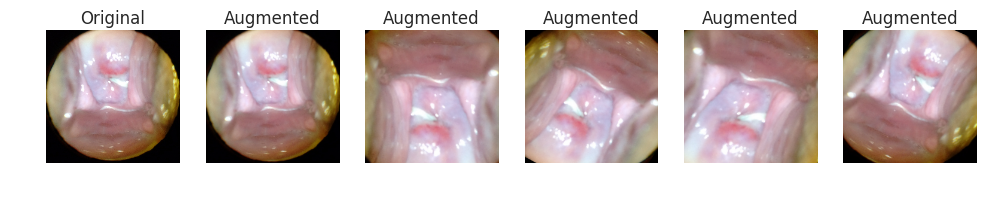

In [14]:
def augment(img,rng,h=224,w=224):
    r_rotate = rng.uniform(-np.pi/6,np.pi/6,1)[0]
    tf_rotate = tf.SimilarityTransform(rotation=r_rotate)
    tf_scale = tf.SimilarityTransform(scale=rng.uniform(1,1.5,1))
    tf_shear = tf.AffineTransform(shear=rng.uniform(-0.1,0.1,1))
    tf_shift = tf.SimilarityTransform(translation=[-w/2, -h/2])
    tf_shift_inv = tf.SimilarityTransform(translation=[w/2, h/2])
    trans = tf_shift + tf_scale + tf_shear + tf_rotate + tf_shift_inv

    img_aug = tf.warp(img, trans.inverse)
    # randomly flip vertically
    if rng.uniform() > 0.5:
        img_aug = img_aug[::-1,:,:]
    # randomly flip horizontally
    if rng.uniform() > 0.5:
        img_aug = img_aug[:,::-1,:]

    return img_aug

# plot with and without augmentation
plt.figure(figsize=(12,3))
plt.subplot(161)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
for i in range(2,7):
    plt.subplot(1,6,i)
    plt.imshow(augment(im,np.random.RandomState(i))) # sample augment
    plt.title('Augmented')
    plt.axis('off')

In [15]:
df_aug = pd.DataFrame()
n_aug = 2000 # number of images to augment to per class

for cl in df.category.unique():
    
    # get number of provided images
    n_provided = (df.category == cl).sum()
    
    # upsample the difference, and append below
    category_upsampled = df[df.category == cl].sample(n=n_aug-n_provided,replace=True,random_state=1)
    df_aug = pd.concat([df_aug,category_upsampled])

print(df_aug.groupby('category').count()) # display number of images to upsample by category
print(len(df_aug))

          fpath     h     w  fname
category                          
1          1751  1751  1751   1751
2          1219  1219  1219   1219
3          1550  1550  1550   1550
4520


In [16]:
# read X back from hdf5
f = h5py.File("data/train.h5", "r")
X = f.get('train/img_cropped_resized_scaled')[...]
f.close()

In [17]:
t = time()

X_aug = np.zeros((len(df_aug),h,w,ch))
Y_aug = df_aug.category
rng = np.random.RandomState(1)
for i in range(len(df_aug)):
    fpath = df_aug.fpath.iloc[i]
    ix = df[df.fpath==fpath].index[0]
    x = X[ix,...]
    x_aug = augment(x,rng)
    X_aug[i,...] = x_aug
    if i % 100 == 0:
        print('Augmented %ith image' % i)

print('Reading took %is' % int(time()-t))

Augmented 0th image
Augmented 100th image
Augmented 200th image
Augmented 300th image
Augmented 400th image
Augmented 500th image
Augmented 600th image
Augmented 700th image
Augmented 800th image
Augmented 900th image
Augmented 1000th image
Augmented 1100th image
Augmented 1200th image
Augmented 1300th image
Augmented 1400th image
Augmented 1500th image
Augmented 1600th image
Augmented 1700th image
Augmented 1800th image
Augmented 1900th image
Augmented 2000th image
Augmented 2100th image
Augmented 2200th image
Augmented 2300th image
Augmented 2400th image
Augmented 2500th image
Augmented 2600th image
Augmented 2700th image
Augmented 2800th image
Augmented 2900th image
Augmented 3000th image
Augmented 3100th image
Augmented 3200th image
Augmented 3300th image
Augmented 3400th image
Augmented 3500th image
Augmented 3600th image
Augmented 3700th image
Augmented 3800th image
Augmented 3900th image
Augmented 4000th image
Augmented 4100th image
Augmented 4200th image
Augmented 4300th image


In [18]:
%%time
features_train_aug = vgg_none.predict(X_aug,verbose=1)
print(features_train_aug.shape)

4520/4520 [==============================] - 7546s   
(4520, 7, 7, 512)
CPU times: user 3h 58min 18s, sys: 12min 25s, total: 4h 10min 44s
Wall time: 2h 5min 46s


In [19]:
f = h5py.File("data/train.h5", "a")
n2 = len(df_aug)

# save labels
dY = f.create_dataset("train/Y_aug", (n2,), dtype='int8')
dY[...] = Y_aug

# save our features
df_train_aug = f.create_dataset("train/X_aug", (n2,7,7,512), dtype='float64')
df_train_aug[...] = features_train_aug
f.close()